In [2]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# Load csv
mouse_drug_data_to_load = "mouse_drug_data.csv"
clinical_trial_data_to_load = "clinicaltrial_data.csv"

# Read the Mouse and Drug Data and the Clinical Trial Data
mouse_df = pd.read_csv(mouse_drug_data_to_load)
trial_df = pd.read_csv(clinical_trial_data_to_load)

# Combine the data into a single dataset (mt = mouse trial)
mt_df = pd.merge(mouse_df, trial_df, on = "Mouse ID")

# Display the data table for preview
mt_df.head()

,Mouse ID,Drug,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,f234,Stelasyn,0,45.000000,0
1,f234,Stelasyn,5,47.313491,0
2,f234,Stelasyn,10,47.904324,0
3,f234,Stelasyn,15,48.735197,1
4,f234,Stelasyn,20,51.112713,2


## Study overview
The study appears to have used a repeated measures design. This means that the same group of mice were subjected to the same drug and the effects were measured over time. The response variables were the tumour volumes and the numbers of metastatic sites. 

In [3]:
# list of subjects and treatments
mouse = mt_df["Mouse ID"].unique()
drugs = mt_df["Drug"].unique()
time = mt_df["Timepoint"].unique()

# counts of subjects and treatments
mouse_popn = len(mouse)
no_drugs = len(drugs)
no_measurements = len(time)
no_samples = no_drugs * no_measurements

# summarise in a dataframe
overview = pd.DataFrame({"Number of Mice": [mouse_popn],
                         "Number of Drug Treatments": [no_drugs],
                         "Number of Time Measurements": [no_measurements],
                         "Number of Samples": [no_samples]})
overview

,Number of Mice,Number of Drug Treatments,Number of Time Measurements,Number of Samples
0,249,10,10,100


## Tumor Response to Treatment

In [4]:
# Group the data by drug and timepoint
mt_df2 = mt_df.drop("Metastatic Sites", axis = 1)
mt_grped = mt_df2.groupby(["Drug","Timepoint"])

# Get the mean and SEM of tumour volume
tumour_means = pd.DataFrame(mt_grped["Tumor Volume (mm3)"].mean()) # mean for each Drug-Timepoint combination
tumour_sem = pd.DataFrame(mt_grped["Tumor Volume (mm3)"].sem()) # SEM for each Drug-Timepoint combination

# reshape the data
tumour_means = tumour_means.unstack(0)
tumour_sem = tumour_sem.unstack(0)

tumour_means = tumour_means["Tumor Volume (mm3)"]
tumour_sem = tumour_sem["Tumor Volume (mm3)"]

In [5]:
# Calculate slopes
slopes_tumour = round(tumour_means.apply(lambda x: np.polyfit(tumour_means.index, x, 1)[0]),2)
slopes_tumour

Drug
Capomulin   -0.20
Ceftamin     0.43
Infubinol    0.46
Ketapril     0.56
Naftisol     0.54
Placebo      0.52
Propriva     0.46
Ramicane    -0.21
Stelasyn     0.52
Zoniferol    0.46
dtype: float64

In [6]:
# Choose ggplot as style for plots
plt.style.use('ggplot')

# Size of plots
fig_size = plt.rcParams["figure.figsize"] # get current size
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size # customise plot size

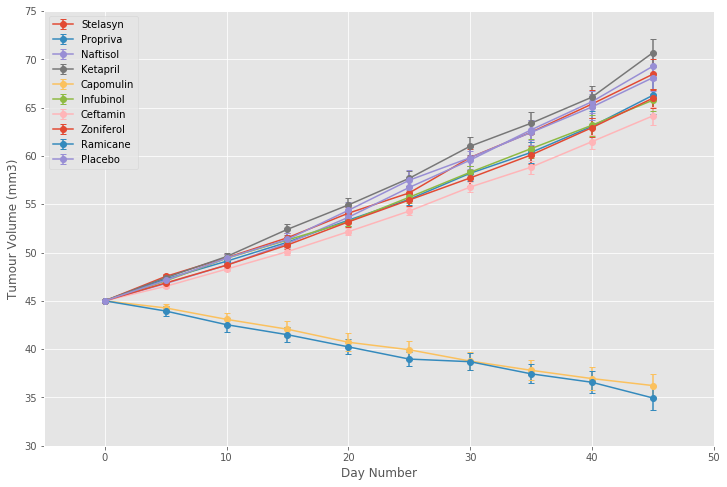

In [7]:
# Plot means and SE

x_axis = np.arange(0,time.max() + 5, 5) # time
no_series = np.arange(0,no_drugs)

for i in no_series:
    std_error = tumour_sem[drugs[i]]
    plt.errorbar(x_axis, 
                 tumour_means[drugs[i]], 
                 yerr = std_error, 
                 marker = "o", capsize = 3)
    
    plt.xlabel("Day Number")
    plt.ylabel("Tumour Volume (mm3)")
    plt.xlim(-5, max(time) + 5)
    plt.ylim(30, 75)
    plt.legend()
    plt.savefig("Images/tumour_v_time.png")

## Metastatic Response to Treatment

In [8]:
mt_df3 = mt_df.drop("Tumor Volume (mm3)", axis = 1)
mt_grped2 = mt_df3.groupby(["Drug","Timepoint"])

# Get the mean of metastasis sites and convert to dataframe
metastatic_series = mt_grped2["Metastatic Sites"].mean()
metastatic_df = metastatic_series.to_frame().reset_index()

# Preview DataFrame
metastatic_df.head()

,Drug,Timepoint,Metastatic Sites
0,Capomulin,0,0.000000
1,Capomulin,5,0.160000
2,Capomulin,10,0.320000
3,Capomulin,15,0.375000
4,Capomulin,20,0.652174


In [9]:
# Get the mean and SEM of tumour volume
meta_means = pd.DataFrame(mt_grped2["Metastatic Sites"].mean()) # mean for each Drug-Timepoint combination
meta_sem = pd.DataFrame(mt_grped2["Metastatic Sites"].sem()) # SEM for each Drug-Timepoint combination

# reshape the data
meta_means = meta_means.unstack(0)
meta_sem = meta_sem.unstack(0)

meta_means = meta_means["Metastatic Sites"]
meta_sem = meta_sem["Metastatic Sites"]

In [10]:
# Calculate slopes
slopes_meta = round(meta_means.apply(lambda x: np.polyfit(meta_means.index, x, 1)[0]),2)
slopes_meta

Drug
Capomulin    0.03
Ceftamin     0.06
Infubinol    0.05
Ketapril     0.07
Naftisol     0.06
Placebo      0.07
Propriva     0.06
Ramicane     0.03
Stelasyn     0.04
Zoniferol    0.07
dtype: float64

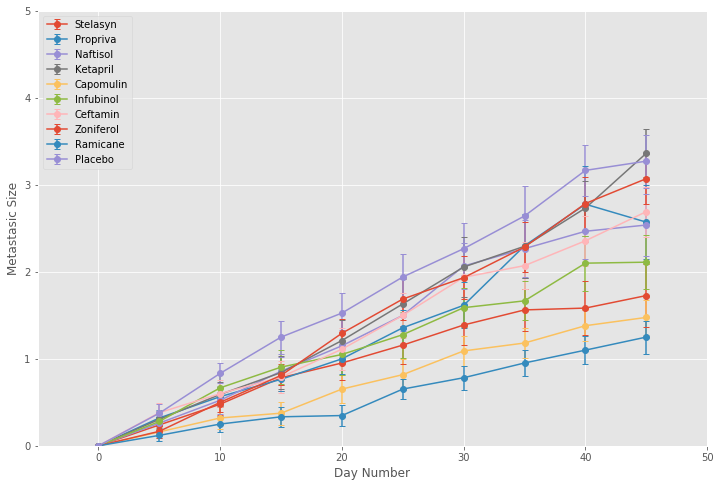

In [11]:
# Plot means and SE

x_axis = np.arange(0,time.max() + 5, 5) # time
no_series = np.arange(0,no_drugs)

for i in no_series:
    std_error = meta_sem[drugs[i]]
    plt.errorbar(x_axis, 
                 meta_means[drugs[i]], 
                 yerr = std_error, 
                 marker = "o", capsize = 3)
    
    plt.xlabel("Day Number")
    plt.ylabel("Metastasic Size")
    plt.xlim(-5, max(time) + 5)
    plt.ylim(0, 5)
    plt.legend()
    plt.savefig("Images/meta_v_time.png")

## Survival Rates

In [12]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)
no_mice = mt_grped["Mouse ID"].count()
no_mice = pd.DataFrame(no_mice.unstack(0))
no_mice

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,25,25,25,25,25,25,26,25,26,25
5,25,21,25,23,23,24,25,25,25,24
10,25,20,21,22,21,24,23,24,23,22
15,24,19,21,19,21,20,17,24,23,21
20,23,18,20,19,20,19,17,23,21,17
25,22,18,18,19,18,17,14,23,19,16
30,22,16,17,18,15,15,13,23,18,15
35,22,14,12,17,15,14,10,21,16,14
40,21,14,10,15,15,12,9,20,12,14


In [13]:
# Calculate slopes
slopes_mice = round(no_mice.apply(lambda x: np.polyfit(no_mice.index, x, 1)[0]),2)
slopes_mice

Drug
Capomulin   -0.10
Ceftamin    -0.24
Infubinol   -0.37
Ketapril    -0.25
Naftisol    -0.26
Placebo     -0.34
Propriva    -0.44
Ramicane    -0.12
Stelasyn    -0.34
Zoniferol   -0.28
dtype: float64

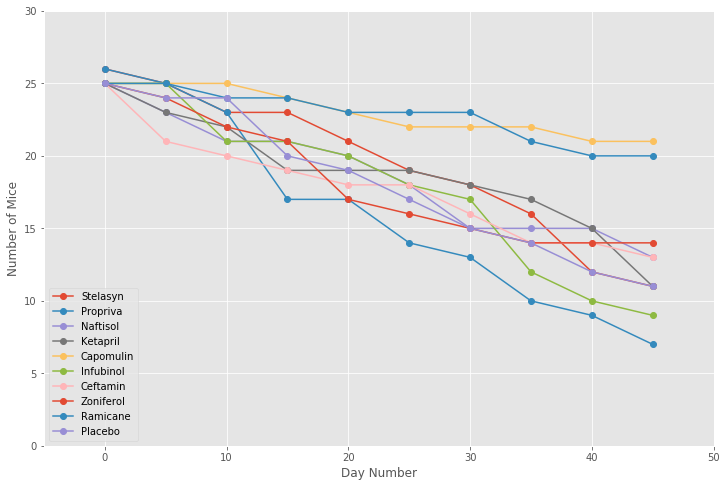

In [14]:
# Plot means and SE

x_axis = np.arange(0,time.max() + 5, 5) # time
no_series = np.arange(0,no_drugs)

for i in no_series:
    plt.plot(x_axis, 
             no_mice[drugs[i]], 
             marker = "o")
    
    plt.xlabel("Day Number")
    plt.ylabel("Number of Mice")
    plt.xlim(-5, max(time) + 5)
    plt.ylim(0, 30)
    plt.legend()
    plt.savefig("Images/mice_v_time.png")

In [15]:
# Percentage of mouse survival
no_mice_0 = no_mice.iloc[0]
pct_mice = round(((no_mice / no_mice_0) * 100), 2)
pct_mice

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,100.0,100.0,100.0,100.0,100.0,100.0,100.00,100.0,100.00,100.0
5,100.0,84.0,100.0,92.0,92.0,96.0,96.15,100.0,96.15,96.0
10,100.0,80.0,84.0,88.0,84.0,96.0,88.46,96.0,88.46,88.0
15,96.0,76.0,84.0,76.0,84.0,80.0,65.38,96.0,88.46,84.0
20,92.0,72.0,80.0,76.0,80.0,76.0,65.38,92.0,80.77,68.0
25,88.0,72.0,72.0,76.0,72.0,68.0,53.85,92.0,73.08,64.0
30,88.0,64.0,68.0,72.0,60.0,60.0,50.00,92.0,69.23,60.0
35,88.0,56.0,48.0,68.0,60.0,56.0,38.46,84.0,61.54,56.0
40,84.0,56.0,40.0,60.0,60.0,48.0,34.62,80.0,46.15,56.0


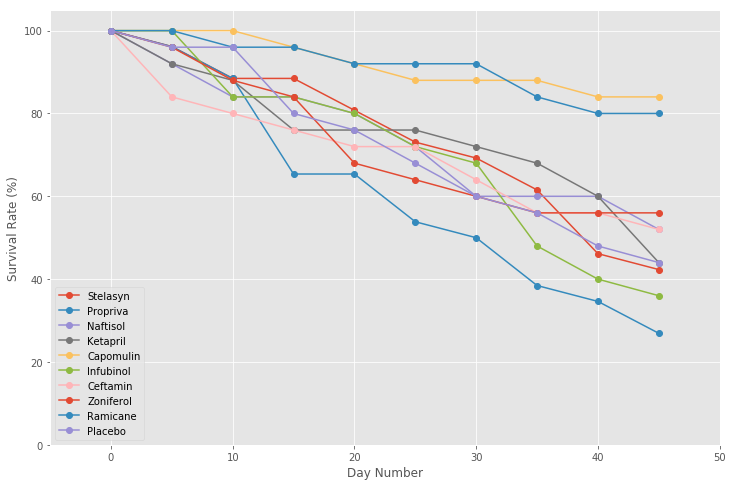

In [16]:
# Plot means and SE

x_axis = np.arange(0,time.max() + 5, 5) # time
no_series = np.arange(0,no_drugs)

for i in no_series:
    plt.plot(x_axis, 
             pct_mice[drugs[i]], 
             marker = "o")
    
    plt.xlabel("Day Number")
    plt.ylabel("Survival Rate (%)")
    plt.xlim(-5, max(time) + 5)
    plt.ylim(0, 105)
    plt.legend()
    plt.savefig("Images/pct_mice_v_time.png")

## Summary Bar Graph

In [21]:
# Plotting
mt_df["Tumor Volume (mm3)"].groupby().plot(kind = "bar")


TypeError: You have to supply one of 'by' and 'level'

In [18]:
# Store all Relevant Percent Changes into a Tuple


# Splice the data between passing and failing drugs


# Orient widths. Add labels, tick marks, etc. 


# Use functions to label the percentages of changes


# Call functions to implement the function calls


# Save the Figure


# Show the Figure
fig.show()

NameError: name 'fig' is not defined